# Using Pyspark, analysis of Bitcoin based on historical data 

**What have we done:**
- Importing Bitcoin Historical dataset to Apache Spark.
- Understanding of the dataset
- Visualizing the data 
- Performing analysis by Linear Regression
- Presenting/Visualizing results.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [8]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 50.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0ab714b6c2d28387404becd55931de7807e2be90b0178d6b55943bf9eb2eed12
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [9]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
#visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

**Starting Spark Session**

In [12]:
sc = SparkContext(appName = "Bitcoin_Analysis")
spark = SparkSession.Builder().getOrCreate()

In [13]:
spark

In [14]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


**Performing Apache Spark commands using PySpark**

In [15]:
df= sqlContext.read.csv('/content/drive/MyDrive/Dataset/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv', header='true', inferSchema='true')

df.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

In [16]:
#getting the schema info from the dataframe
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [17]:
# Count total number of rows
df.count()
# Count the total number of columns
len(df.columns)

4363457

8

In [18]:
df.createOrReplaceTempView('bitstampUSD') #creating a temp view table
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
bitstampUSD=bitstampUSD.dropna('any') # Removing null values

In [19]:
bitstampUSD.show()
# Count total number of rows after removing the null values
bitstampUSD.count()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 15:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 16:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 17:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 04:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 15:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 22:45:00|


3126480

In [20]:
#Renaming the columns 
bitstampUSD=bitstampUSD.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [21]:
#Creating another dataframe to perform Datetime Visualization 
DateTime_df= bitstampUSD

In [22]:
#Splitting the dataframe by required columns
splitDF = DateTime_df.withColumn("date",split(col("dateTime")," ").getItem(0))
splitDF = splitDF.withColumn("time",split(col("dateTime")," ").getItem(1))

In [23]:
#Splitting the dataframe by required columns
splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))

In [24]:
#Arranging Dataframe with column date and time and day_of_week
splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime",splitDFHour["dateTime"].cast(DateType()))
splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))

In [25]:
#Arranging Dataframe with column date and time and year
splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
splitDFWithYear.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|07:52:00| 7.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|15:50:00|15.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|16:59:00|16.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|17:00:00|17.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|04:16:00| 4.0|  

In [26]:
# Spark to Pandas dataframe
pandas_converted=splitDFWithYear.toPandas()

In [27]:
#Getting the values in list so that we can plot and visualize it
hour=pandas_converted["hour"].values.tolist()
weighted_price=pandas_converted["Weighted_Price"].values.tolist()
volume_BTC=pandas_converted["VolBTC"].values.tolist()
date_of_week=pandas_converted["day_of_week"].values.tolist()
year=pandas_converted["year"].values.tolist()

**Data Visualization**

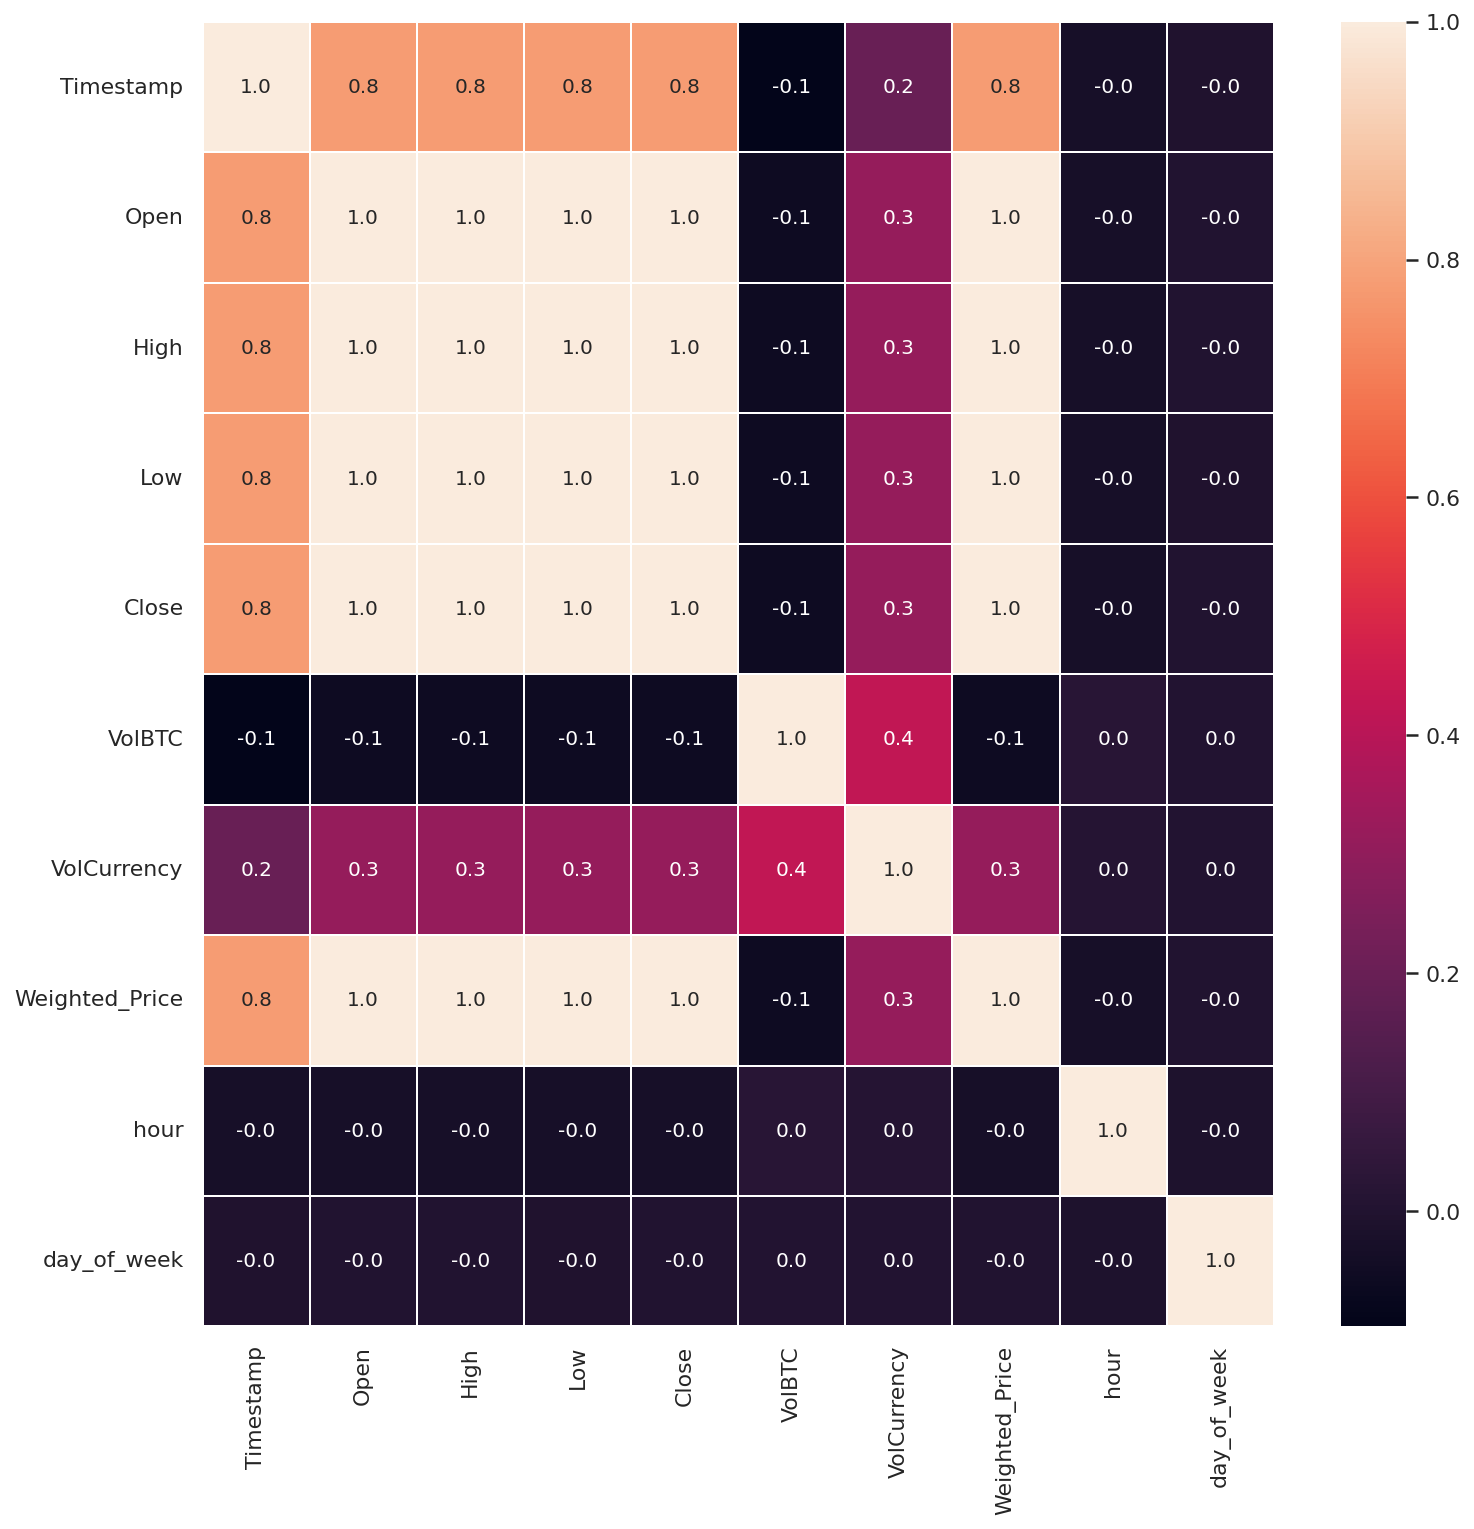

In [28]:
#Correlation plotting the heatmap using Seaborn
corr=pandas_converted.corr()
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.1f',ax=ax)

<Figure size 1152x288 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Line plot')

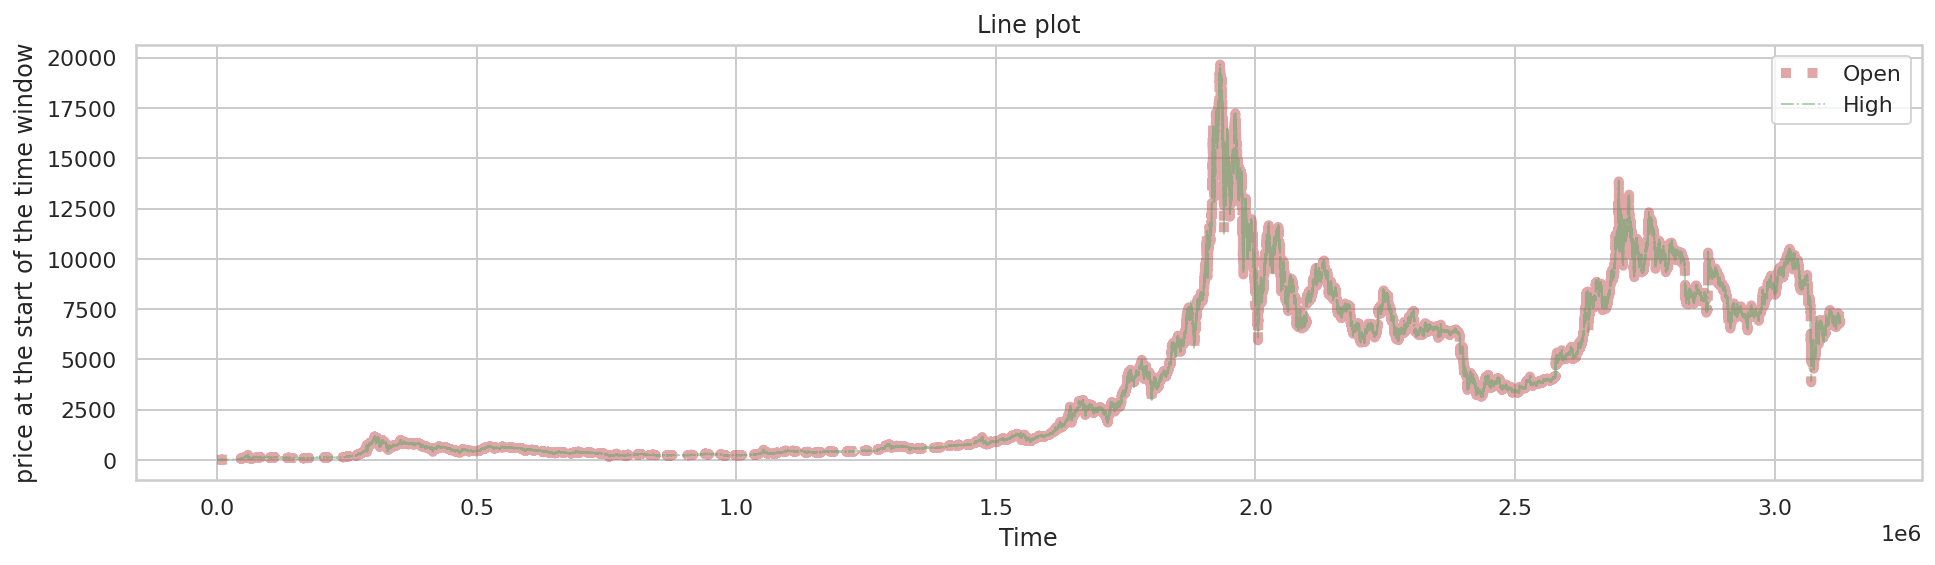

In [29]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind='line', color='r', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandas_converted.High.plot(color='g', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') #legend put label into plot
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Line plot')
plt.show()

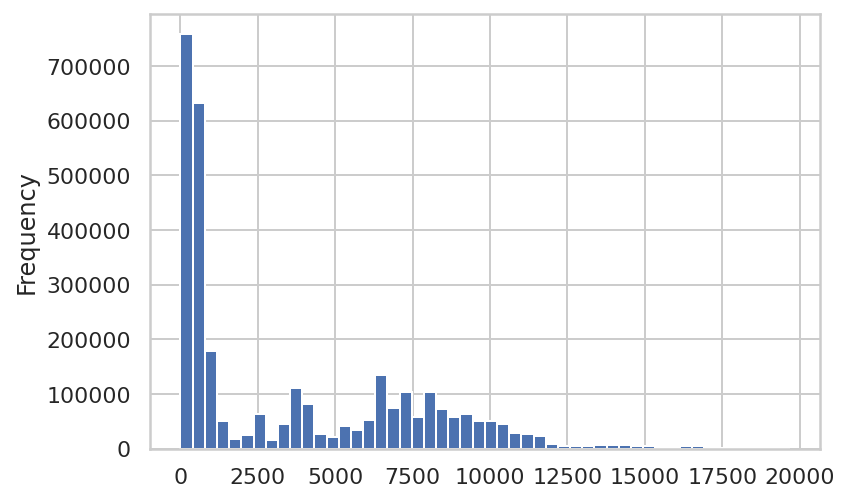

In [30]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind='hist', bins=50)

**Feature Engineering/Extraction**

In [31]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=['Open','High', 'VolBTC', 'VolCurrency','Weighted_Price'], outputCol="features")
assembled_df = assembler.transform(bitstampUSD)
assembled_df.show(10, truncate= False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                                        |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 07:52:00|[4.39,4.39,0.45558087,2.0000000193,4.39]        |
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 15:50:00|[4.39,4.39,48.0,210.72,4.39]                    |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 16:59:00|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 17:00:00|[4.58,4.58,9.0,41.22,4.58]                      |

**Normalization**

In [32]:
# Initialize the `Min_Max_scaler`
Min_Max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# Fit the DataFrame to the scaler
scaled_df= Min_Max_scaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "scaled_features").show(10, truncate=False)
scaled_df.columns

+------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|features                                        |scaled_features                                                                                              |
+------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|[4.39,4.39,0.45558087,2.0000000193,4.39]        |[3.000718137967933E-5,3.0006815107159923E-5,7.782582427582654E-5,2.642204437533844E-7,3.001093788611932E-5]  |
|[4.39,4.39,48.0,210.72,4.39]                    |[3.000718137967933E-5,3.0006815107159923E-5,0.008199728766573702,2.7838265685217316E-5,3.001093788611932E-5] |
|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|[3.560174061995855E-5,3.916143666527654E-5,0.006467928495112392,2.2641094197904138E-5,3.6949644669905385E-5] |
|[4.58,4.58,9.0,41.22,4.58]       

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

**Machine Learning Model With Spark ML**

In [33]:
# Split the data into train,test and Validation sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

**ElasticNet Linear Regression Model**

In [34]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='scaled_features' , labelCol="Weighted_Price", predictionCol='Predicted_price', maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [35]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [36]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|6.183490579660492|          4.39|
|6.793033442028951|           5.0|
| 7.11279363212388|          5.32|
| 7.08281611430248|          5.29|
|7.156245990646434|  5.3604618117|
|  7.5647917203173|   5.777027027|
|7.792284036075603|           6.0|
| 8.23195429745613|          6.44|
|8.211969285575197|          6.42|
|8.441796922205928|          6.65|
+-----------------+--------------+
only showing top 10 rows



In [37]:
# Select (predicted_price, Weighted_price label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.51621


In [41]:
#prediction on test data. Calculate Root Mean Square Error of our model.
predictionsTest = linearModel.transform(test_data)
predictionsTest.select("Predicted_price", "Weighted_Price").show(10)

rmse = evaluator.evaluate(predictionsTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|6.183490579660492|          4.39|
|6.793033442028951|           5.0|
| 7.11279363212388|          5.32|
| 7.08281611430248|          5.29|
|7.156245990646434|  5.3604618117|
|  7.5647917203173|   5.777027027|
|7.792284036075603|           6.0|
| 8.23195429745613|          6.44|
|8.211969285575197|          6.42|
|8.441796922205928|          6.65|
+-----------------+--------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 3.51621


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


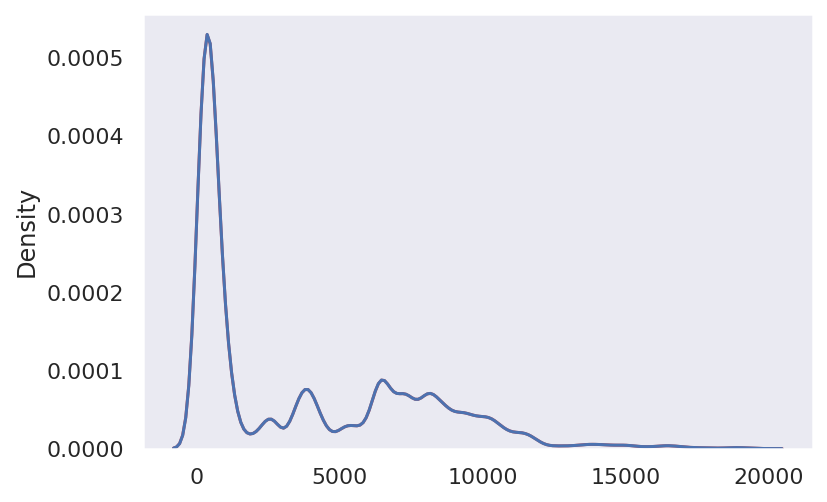

In [42]:
pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Weighted_Price').toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()
sns.set_style("dark")
ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.distplot(_Y, hist=False, color="b", label="Fitted Values" , ax=ax1)

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'BitCoin Weighted Prediction')

Text(0.5, 0, 'Weighted_Price')

Text(0, 0.5, 'Predicted_price')

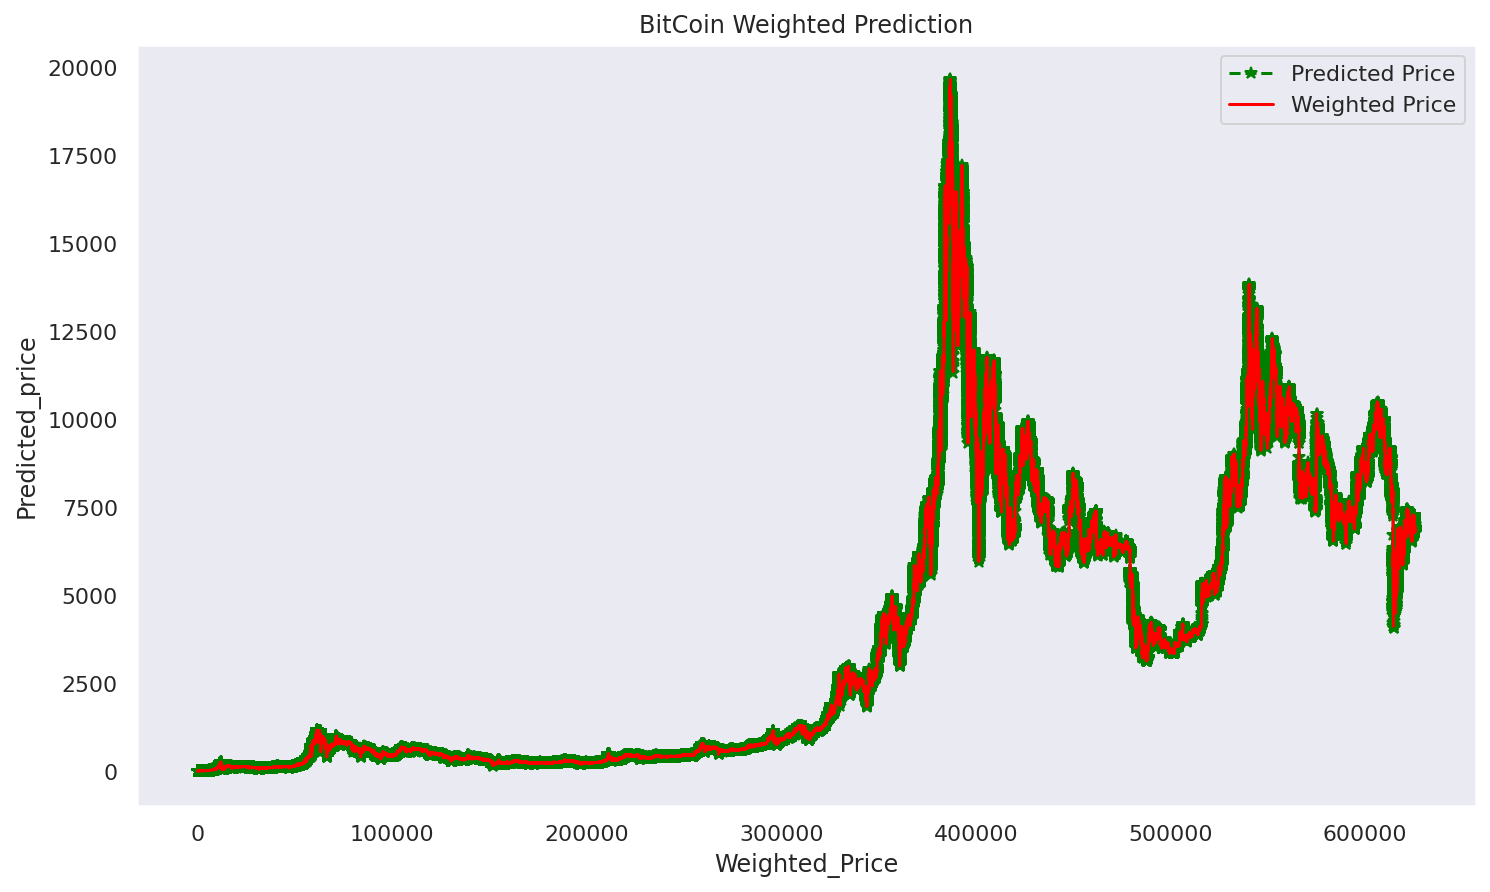

In [43]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('BitCoin Weighted Prediction')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()

In [44]:
spark.stop()